In [1]:
import _pickle as pickle
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import timeit

from itertools import product

In [2]:
map_eval_name = {
    "pretraining": "",
    "pretrain-sample_high_prob_class_only-start_pos_0": "Condition on High Frequency",
    "pretrain-sample_low_prob_class_only-start_pos_0": "Condition on Low Frequency",
    "pretrain-sample_high_prob_class_only-start_pos_0-flip_label": "Condition on High Frequency",
    "pretrain-sample_low_prob_class_only-start_pos_0-flip_label": "Condition on Low Frequency",
    
    "pretrain-sample_high_prob_class_only-start_pos_1": "Condition on High Frequency",
    "pretrain-sample_low_prob_class_only-start_pos_1": "Condition on Low Frequency",
    "pretrain-sample_high_prob_class_only-start_pos_1-flip_label": "Condition on High Frequency",
    "pretrain-sample_low_prob_class_only-start_pos_1-flip_label": "Condition on Low Frequency",
    
    "pretrain-sample_high_prob_class_only-start_pos_7": "Condition on High Frequency",
    "pretrain-sample_low_prob_class_only-start_pos_7": "Condition on Low Frequency",
    "pretrain-sample_high_prob_class_only-start_pos_7-flip_label": "Condition on High Frequency",
    "pretrain-sample_low_prob_class_only-start_pos_7-flip_label": "Condition on Low Frequency",

    "eval-relevant_context-none": "Relevant Context",
    "eval-irrelevant_context-none": "Irrelevant Context",
}

stats_keys = [
    "accuracy",
    "p_iwl",
    "context contains query class",
    "loss",
    "ic_pred",
    "iw_pred",
]

In [3]:
repo_path = "/Users/chanb/research/ualberta/icl/simple_icl"
# results_dir = "/Users/chanb/research/ualberta/icl/scratch/evaluation_results"
# results_dir = "/Users/chanb/research/ualberta/icl/cc_results/evaluation_results"
results_dir = "/Users/chanb/research/ualberta/icl/cc_results/noisy_labels_0.01/evaluation_results"

# repo_path = "/home/chanb/src/simple_icl"
# results_dir = "/home/chanb/scratch/simple_icl/results"

In [4]:
# variant_name = "synthetic-simple_icl"
# variant_name = "synthetic-transformer"
variant_name = "synthetic-transformer-context_len"
# variant_name = "synthetic-transformer-large_num_low_freq"
variant_name = "synthetic-transformer-large_num_low_freq-input_noise_0.2"
# variant_name = "synthetic-transformer-no_noise"
# variant_name = "synthetic-transformer-noisy_inputs_0.2"
# variant_name = "synthetic-transformer-noisy_labels_0.01"
# variant_name = "synthetic-transformer-noisy_labels_0.1"
# variant_name = "synthetic-transformer-num_relevant_contexts"

checkpoint_steps = 500

stats_file = os.path.join(repo_path, "plot_utils/plots/agg_stats", "{}.feather".format(variant_name))
stats = pd.read_feather(stats_file)

os.makedirs(
    os.path.join(repo_path, "plot_utils/plots/acc-plots", variant_name),
    exist_ok=True
)

results_dir = os.path.join(results_dir, variant_name)
eval_namess = [
    [
        "pretraining"
    ],
    [
        "eval-relevant_context-none",
        "eval-irrelevant_context-none",
    ],
    [
        "pretrain-sample_high_prob_class_only-start_pos_0",
        "pretrain-sample_low_prob_class_only-start_pos_0",
    ],
    [
        "pretrain-sample_high_prob_class_only-start_pos_0-flip_label",
        "pretrain-sample_low_prob_class_only-start_pos_0-flip_label",
    ],
    [
        "pretrain-sample_high_prob_class_only-start_pos_1",
        "pretrain-sample_low_prob_class_only-start_pos_1",
    ],
    [
        "pretrain-sample_high_prob_class_only-start_pos_1-flip_label",
        "pretrain-sample_low_prob_class_only-start_pos_1-flip_label",
    ],
    [
        "pretrain-sample_high_prob_class_only-start_pos_7",
        "pretrain-sample_low_prob_class_only-start_pos_7",
    ],
    [
        "pretrain-sample_high_prob_class_only-start_pos_7-flip_label",
        "pretrain-sample_low_prob_class_only-start_pos_7-flip_label",
    ],
]
plot_names = [
    "pretraining",
    "context-default",
    "iwl",
    "iwl-flip_label",
    "icl-last_context",
    "icl-last_context-flip_label",
    "icl-except_first_context",
    "icl-except_first_context-flip_label",
]
plot_titles = [
    "Pretraining",
    "Context Default"
    "In-weight Evaluation",
    "In-weight Evaluation with Flipped Label",
    "In-context Evaluation with Last Context",
    "In-context Evaluation with Last Context + Flipped Label",
    "In-context Evaluation with Contexts but First",
    "In-context Evaluation with Contexts but First + Flipped Label",
]

map_stats_key = {
    "p_iwl": "$\\alpha(x)$",
    "accuracy": "Accuracy",
    "context contains query class": "Context Contains Query Class",
    "loss": "Loss",
    "ic_pred": "In-context Accuracy",
    "iw_pred": "In-weight Accuracy"
}

map_variant = {
    "ground_truth_prob": "$P(g(x) = c)$",
    "high_prob": "$P(high\_freq.)$"
}

In [5]:
variants = stats["variant"].unique()

# Plot Accuracy based on Checkpoint Intervals

In [ ]:
stats["stats_key"].unique()

In [ ]:
stats["eval_name"].unique()

In [ ]:
for eval_names, plot_name, plot_title in zip(eval_namess, plot_names, plot_titles):
    tic = timeit.default_timer()

    agg_stats = dict()
    for variant in variants:
        agg_stats.setdefault(variant, dict())
        for eval_name in eval_names:
            agg_stats[variant].setdefault(eval_name, dict())
            for stats_key in stats_keys:
                curr_stats = stats.loc[
                    (stats["variant"] == variant)
                    & (stats["eval_name"] == eval_name)
                    & (stats["stats_key"] == stats_key)
                ]["stats"].to_list()

                if len(curr_stats) == 0:
                    continue
                agg_stats[variant][eval_name][stats_key] = (
                    np.mean(curr_stats, axis=0),
                    np.std(curr_stats, axis=0),
                )

    for variant in variants:
        os.makedirs(os.path.join(repo_path, "plot_utils/plots/acc-plots", variant_name, variant), exist_ok=True)
        for stats_key in stats_keys:
            if stats_key in ["p_iwl", "context contains query class"]:
                continue
            if stats_key not in agg_stats[variant][eval_name]:
                print("{} skipped".format(stats_key))
                continue

            fig, axes = plt.subplots(1, len(eval_names), figsize=(5 * len(eval_names), 5))
            for eval_i, eval_name in enumerate(eval_names):
                if len(eval_names) > 1:
                    ax = axes[eval_i]
                else:
                    ax = axes
                x_range = np.arange(len(agg_stats[variant][eval_name]["accuracy"][0])) * checkpoint_steps
                ax.plot(
                    x_range,
                    np.array(agg_stats[variant][eval_name][stats_key][0]),
                    label="Model" if eval_i == 0 else "",
                    linewidth=3,
                    c="red",
                    alpha=0.7,
                )
                
                if "p_iwl" in agg_stats[variant][eval_name]:
                    ax.plot(
                        x_range,
                        agg_stats[variant][eval_name]["p_iwl"][0],
                        label="$\\alpha(x)$" if eval_i == 0 else "",
                        linestyle="--",
                        c="black",
                        alpha=0.3
                    )
                ax.plot(
                    x_range,
                    agg_stats[variant][eval_name]["context contains query class"][0],
                    label="% $\geq 1$ Context from Query Class" if eval_i == 0 else "",
                    linestyle="-.",
                    c="black",
                    alpha=0.3
                )
                ax.set_ylim(-0.1, 1.1)
                ax.set_title(map_eval_name[eval_name])

            fig.supylabel(map_stats_key[stats_key])
            fig.supxlabel("Gradient Steps")
            fig.suptitle(plot_title)
            fig.legend(
                bbox_to_anchor=(0.0, 1.0, 1.0, 0.0),
                loc="lower center",
                ncols=5,
                borderaxespad=0.0,
                frameon=True,
                fontsize="8", 
            )

            plt.savefig(
                os.path.join(repo_path, "plot_utils/plots/acc-plots", "{}/{}/{}-{}.png".format(variant_name, variant, stats_key, plot_name)),
                format="png",
                bbox_inches="tight",
                dpi=600,
            )
            plt.close(fig)

    toc = timeit.default_timer()
    print("Done {} {} {} in {}s".format(variant_name, variant, eval_name, toc - tic))

# Aggregate Important Plots

In [ ]:

eval_names = [
    "pretrain-sample_high_prob_class_only-start_pos_0",
    "pretrain-sample_low_prob_class_only-start_pos_0",
    "pretrain-sample_high_prob_class_only-start_pos_0-flip_label",
    "pretrain-sample_low_prob_class_only-start_pos_0-flip_label",
    "pretrain-sample_high_prob_class_only-start_pos_1",
    "pretrain-sample_low_prob_class_only-start_pos_1",
    "pretrain-sample_high_prob_class_only-start_pos_1-flip_label",
    "pretrain-sample_low_prob_class_only-start_pos_1-flip_label",
]

y_axis_groups = [
    "Start Pos @ 0",
    "Start Pos @ 0 w/ Flipped",
    "Start Pos @ 1",
    "Start Pos @ 1 w/ Flipped",
]

In [ ]:

tic = timeit.default_timer()

agg_stats = dict()
for variant in variants:
    agg_stats.setdefault(variant, dict())
    for eval_name in eval_names:
        agg_stats[variant].setdefault(eval_name, dict())
        for stats_key in stats_keys:
            curr_stats = stats.loc[
                (stats["variant"] == variant)
                & (stats["eval_name"] == eval_name)
                & (stats["stats_key"] == stats_key)
            ]["stats"].to_list()

            if len(curr_stats) == 0:
                continue
            agg_stats[variant][eval_name][stats_key] = (
                np.mean(curr_stats, axis=0),
                np.std(curr_stats, axis=0),
            )

for variant in variants:
    os.makedirs(os.path.join(repo_path, "plot_utils/plots/acc-plots", variant_name, variant), exist_ok=True)
    for stats_key in stats_keys:
        if stats_key in ["p_iwl", "context contains query class"]:
            continue
        if stats_key not in agg_stats[variant][eval_name]:
            print("{} skipped".format(stats_key))
            continue

        fig, axes = plt.subplots(len(eval_names) // 2, 2, figsize=(7, 3 * len(eval_names) // 2))
        for eval_i, eval_name in enumerate(eval_names):
            if len(eval_names) > 2:
                ax = axes[eval_i // 2, eval_i % 2]
            elif len(eval_names) > 1:
                ax = axes[eval_i]
            else:
                ax = axes
            x_range = np.arange(len(agg_stats[variant][eval_name]["accuracy"][0])) * checkpoint_steps
            ax.plot(
                x_range,
                np.array(agg_stats[variant][eval_name][stats_key][0]),
                label="Model" if eval_i == 0 else "",
                linewidth=3,
                c="red",
                alpha=0.7,
            )
            
            if "p_iwl" in agg_stats[variant][eval_name]:
                ax.plot(
                    x_range,
                    agg_stats[variant][eval_name]["p_iwl"][0],
                    label="$\\alpha(x)$" if eval_i == 0 else "",
                    linestyle="--",
                    c="black",
                    alpha=0.3
                )
            ax.plot(
                x_range,
                agg_stats[variant][eval_name]["context contains query class"][0],
                label="% $\geq 1$ Context from Query Class" if eval_i == 0 else "",
                linestyle="-.",
                c="black",
                alpha=0.3
            )
            ax.set_ylim(-0.1, 1.1)
            ax.ticklabel_format(style='sci', scilimits=(0, 0), axis='x')

            if eval_i < 2:
                ax.set_title(map_eval_name[eval_name])

            if eval_i % 2 == 0:
                ax.set_ylabel(y_axis_groups[eval_i // 2])

        fig.supylabel(map_stats_key[stats_key])
        fig.supxlabel("Gradient Steps")
        # fig.suptitle(plot_title)
        fig.legend(
            bbox_to_anchor=(0.0, 1.0, 1.0, 0.0),
            loc="lower center",
            ncols=5,
            borderaxespad=0.0,
            frameon=True,
            fontsize="8", 
        )

        plt.tight_layout()
        plt.savefig(
            os.path.join(repo_path, "plot_utils/plots/acc-plots", "{}/{}/{}-combined.png".format(variant_name, variant, stats_key)),
            format="png",
            bbox_inches="tight",
            dpi=600,
        )
        plt.close(fig)

toc = timeit.default_timer()
print("Done {} {} {} in {}s".format(variant_name, variant, eval_name, toc - tic))

# Bias-Variance IC Predictor and IW Predictor
For fixed $h$ and $g$ we have zero variance.

In [ ]:
stats

In [ ]:
eval_names = [
    "pretrain-sample_high_prob_class_only-start_pos_0",
    "pretrain-sample_low_prob_class_only-start_pos_0",
    "pretrain-sample_high_prob_class_only-start_pos_1",
    "pretrain-sample_low_prob_class_only-start_pos_1",
]
high_prob_values = stats["high_prob"].unique()

stats_keys = [
    "p_iwl",
    "context contains query class",
]
y_axis_groups = [
    "Start Pos @ 0",
    "Start Pos @ 1",
]
x_axis_groups = [
    "P(g(x) = high freq. | x $\\in$ high freq.)",
    "1 - P(g(x) = low freq. | x $\\in$ low freq.)"
]

In [ ]:
# TODO: Think about how to plot this
agg_stats = dict()
for eval_name in eval_names:
    agg_stats[eval_name] = dict()
    for high_prob_value in high_prob_values:
        agg_stats[eval_name].setdefault(high_prob_value, dict())
        for stats_key in stats_keys:
            curr_stats = stats.loc[
                (stats["high_prob"] == high_prob_value)
                & (stats["eval_name"] == eval_name)
                & (stats["stats_key"] == stats_key)
            ]["stats"].to_list()

            if len(curr_stats) == 0:
                continue
            agg_stats[eval_name][high_prob_value][stats_key] = (
                np.mean(curr_stats, axis=0),
                np.std(curr_stats, axis=0),
            )

x_range = sorted(high_prob_values)
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
for eval_i, eval_name in enumerate(eval_names):
    if len(eval_names) > 2:
        ax = axes[eval_i // 2, eval_i % 2]
    elif len(eval_names) > 1:
        ax = axes[eval_i]
    else:
        ax = axes

    means = np.array([agg_stats[eval_name][high_prob_value]["p_iwl"][0][-1] for high_prob_value in x_range])
    stds = np.array([agg_stats[eval_name][high_prob_value]["p_iwl"][1][-1] for high_prob_value in x_range])
    ax.plot(
        x_range,
        means,
        label="$\\alpha(x)$" if eval_i == 0 else ""
    )

    ax.fill_between(
        x_range,
        means - stds,
        means + stds,
        alpha=0.2,
    )

    ax.plot(
        x_range,
        [agg_stats[eval_name][high_prob_value]["context contains query class"][0][-1] for high_prob_value in x_range],
        label="% $\geq 1$ Context from Query Class" if eval_i == 0 else "",
        linestyle="-."
    )

    ax.set_ylim(-0.1, 1.1)

    # if eval_i < 2:
    #     ax.set_title(map_eval_name[eval_name])
    
    if eval_i >= 2:
        ax.set_xlabel(x_axis_groups[eval_i % 2])

    if eval_i % 2 == 0:
        ax.set_ylabel(y_axis_groups[eval_i // 2])

fig.supxlabel("P(high freq.)")
fig.legend(
    bbox_to_anchor=(0.0, 1.0, 1.0, 0.0),
    loc="lower center",
    ncols=2,
    borderaxespad=0.0,
    frameon=True,
    fontsize="8", 
)

plt.tight_layout()
plt.show()


In [ ]:
variant_1 = "high_prob"
variant_2 = "ground_truth_prob"

variant_1_values = sorted([float(el) for el in stats[variant_1].unique()])
variant_2_values = sorted([float(el) for el in stats[variant_2].unique()])

In [ ]:
def compute_bias_iw(ground_truth_prob):
    return -np.log(np.clip(ground_truth_prob, a_min=1e-8))

def compute_bias_ic(high_prob, label, num_examples=8):
    label_ind = np.argmax(label, axis=-1)
    return -np.log(((num_examples - 1) + ((1 - label_ind) * high_prob + label_ind * (1 - high_prob))) / num_examples, a_min=1e-8)

In [ ]:
checkpoint_i = -1


os.makedirs(
    os.path.join(repo_path, "plot_utils/plots/iw_ic-plots", variant_name),
    exist_ok=True
)

for eval_names, plot_name, plot_title in zip(eval_namess, plot_names, plot_titles):
    tic = timeit.default_timer()

    agg_stats = dict()
    for (variant_1_value, variant_2_value) in product(variant_1_values, variant_2_values):
        agg_stats.setdefault((variant_1_value, variant_2_value), dict())
        for eval_name in eval_names:
            agg_stats[(variant_1_value, variant_2_value)].setdefault(eval_name, dict(mean=[], std=[]))

            for stats_key in ["iw_pred", "ic_pred", "p_iwl"]:
                curr_stats = stats.loc[
                    (stats[variant_1] == str(variant_1_value))
                    & (stats[variant_2] == str(variant_2_value))
                    & (stats["eval_name"] == eval_name)
                    & (stats["stats_key"] == stats_key)
                ]["stats"].to_list()

                agg_stats[(variant_1_value, variant_2_value)][eval_name]["mean-{}".format(stats_key)] = (
                    np.mean(curr_stats, axis=0)[checkpoint_i].item()
                )
                agg_stats[(variant_1_value, variant_2_value)][eval_name]["std-{}".format(stats_key)] = (
                    np.std(curr_stats, axis=0)[checkpoint_i].item()
                )

    fig, axes = plt.subplots(1, len(eval_names), figsize=(1 + 4 * len(eval_names), 5))
    for eval_i, eval_name in enumerate(eval_names):
        if len(eval_names) > 1:
            ax = axes[eval_i]
        else:
            ax = axes

        plot_res = {
            "$e(IW) < e(IC)$": [],
            "$e(IW) > e(IC)$": [],
            "$e(IW) = e(IC)$": [],
        }
        for (variant_1_value, variant_2_value), curr_stats in agg_stats.items():
            acc_delta = (
                np.array(curr_stats[eval_name]["mean-iw_pred"])
                - np.array(curr_stats[eval_name]["mean-ic_pred"])
            )

            if acc_delta > 0:
                plot_key = "$e(IW) < e(IC)$"
            elif acc_delta < 0:
                plot_key = "$e(IW) > e(IC)$"
            else:
                plot_key = "$e(IW) = e(IC)$"

            plot_res[plot_key].append((variant_1_value, variant_2_value, acc_delta, curr_stats[eval_name]["mean-p_iwl"]))

        for plot_key in plot_res:
            curr_data = np.array(plot_res[plot_key])
            if len(curr_data) == 0:
                continue

            ax.scatter(
                curr_data[:, 0],
                curr_data[:, 1],
                s=3 + 20 * np.abs(curr_data[:, 2]),
                label=plot_key if eval_i == 0 else "",
                alpha=np.abs(curr_data[:, 3] - 0.5) * 2,
                marker="o",
            )

        ax.set_title(map_eval_name[eval_name])

    fig.supxlabel(map_variant[variant_1])
    fig.supylabel(map_variant[variant_2])
    # fig.suptitle(plot_title)
    fig.legend(
        bbox_to_anchor=(0.0, 1.0, 1.0, 0.0),
        loc="lower center",
        ncols=math.ceil(len(variant_1_values) / 2),
        borderaxespad=0.0,
        frameon=True,
        fontsize="8", 
    )

    plt.savefig(
        os.path.join(repo_path, "plot_utils/plots/iw_ic-plots", variant_name, "{}.png".format(plot_name)),
        format="png",
        bbox_inches="tight",
        dpi=600,
    )
    plt.close(fig)

    toc = timeit.default_timer()
    print("Done {} {} in {}s".format(variant_name, eval_name, toc - tic))

In [ ]:
# TODO: x y axes the biases, use colour to indicate alpha(x)

# Individual Check

In [ ]:
stats["stats_key"].unique()

In [ ]:
stats.loc[
    # (stats["variant"] == "high_prob_0.8-ground_truth_prob_0.0")
    # & (stats["eval_name"] == "pretrain-sample_low_prob_class_only-start_pos_0")
    # & (stats["seed"] == "seed_0")
    # & (stats["stats_key"] == "p_iwl")
    (stats["eval_name"] == "pretrain-sample_low_prob_class_only-start_pos_0")
    & (stats["seed"] == "seed_0")
    & (stats["stats_key"] == "iw_pred")
]

In [ ]:
stats

In [ ]:
stats["eval_name"].unique()

# Simple ICL

In [ ]:
stats

In [9]:
dataset_sizes = sorted([int(dataset_size) for dataset_size in stats["dataset_size"].unique()])
p_high = 0.99
p_relevant_context = 0.9

In [ ]:
map_label = {
    "synthetic-iw_predictor": "IW Predictor",
    "synthetic-ic_predictor": "IC Predictor",
    "synthetic-alpha": "Simple ICL",
}
map_eval = {
    "eval-relevant_context-high_prob": "Rel. Context, High-freq.",
    "eval-relevant_context-low_prob": "Rel. Context, Low-freq.",
    "eval-irrelevant_context-high_prob": "Irrel. Context, High-freq.",
    "eval-irrelevant_context-low_prob": "Irrel. Context, Low-freq.",
    "eval-relevant_context-high_prob-flip_label": "Rel. Context, High-freq.",
    "eval-relevant_context-low_prob-flip_label": "Rel. Context, Low-freq.",
    "eval-irrelevant_context-high_prob-flip_label": "Irrel. Context, High-freq.",
    "eval-irrelevant_context-low_prob-flip_label": "Irrel. Context, Low-freq.",
}

# fig, axes = plt.subplots(2, 2, figsize=(10, 8))
fig, axes = plt.subplots(2, 4, figsize=(10, 5))
eval_namess = [
    [
        "eval-relevant_context-high_prob",
        "eval-relevant_context-low_prob",
        "eval-irrelevant_context-high_prob",
        "eval-irrelevant_context-low_prob",
    ],
    [
        "eval-relevant_context-high_prob-flip_label",
        "eval-relevant_context-low_prob-flip_label",
        "eval-irrelevant_context-high_prob-flip_label",
        "eval-irrelevant_context-low_prob-flip_label",
    ],
]
for row_i, eval_names in enumerate(eval_namess):
    for eval_i, eval_name in enumerate(eval_names):
        ax = axes[row_i, eval_i]
        # ax = axes[eval_i]
        for predictor in [
            "synthetic-iw_predictor",
            "synthetic-ic_predictor",
            "synthetic-alpha",
        ]:
            losses_mean = []
            losses_std = []

            for dataset_size in dataset_sizes:
                if predictor == "synthetic-alpha":
                    data = np.log10(np.array(stats[
                        (stats["dirname"] == f"{predictor}")
                        & (stats["stats_key"] == "loss")
                        & (stats["eval_name"] == eval_name)
                        & (stats["dataset_size"] == f"{dataset_size}")
                        & (stats["p_high"] == f"{p_high}")
                        & (stats["p_relevant_context"] == f"{p_relevant_context}")
                    ]["stats"].to_list()))
                else:
                    data = np.log10(np.array(stats[
                        (stats["dirname"] == f"{predictor}")
                        & (stats["stats_key"] == "loss")
                        & (stats["eval_name"] == eval_name)
                        & (stats["dataset_size"] == f"{dataset_size}")
                    ]["stats"].to_list()))
                losses_mean.append(np.mean(data, axis=0)[-1])
                losses_std.append(np.std(data, axis=0)[-1])

            losses_mean = np.array(losses_mean)
            losses_std = np.array(losses_std) / np.sqrt(5)

            ax.plot(np.log2(np.array(dataset_sizes)), losses_mean, label=map_label[predictor] if eval_i == 0 and row_i == 0 else "")
            ax.fill_between(np.log2(np.array(dataset_sizes)), losses_mean - losses_std, losses_mean + losses_std, alpha=0.3)

        ax.set_title(map_eval[eval_name])
        if eval_i == 0:
            ax.set_ylabel("$c$" if row_i == 0 else "$(c + 1) \\text{ mod } C$")

        ax.set_ylim(-1.6, 1.6)
fig.supylabel("Cross-entropy Loss")
fig.supxlabel("Dataset Size (in $\\log_2$)")
fig.legend(
    bbox_to_anchor=(0.0, 1.0, 1.0, 0.0),
    loc="lower center",
    ncols=4,
    borderaxespad=0.0,
    frameon=True,
    fontsize="8", 
)
fig.tight_layout()
plt.show()

In [ ]:
map_label = {
    "synthetic-iw_predictor": "IW Predictor",
    "synthetic-ic_predictor": "IC Predictor",
    "synthetic-alpha": "Simple ICL",
}
map_eval = {
    "eval-relevant_context-high_prob": "Rel. Context, High-freq.",
    "eval-relevant_context-low_prob": "Rel. Context, Low-freq.",
    "eval-irrelevant_context-high_prob": "Irrel. Context, High-freq.",
    "eval-irrelevant_context-low_prob": "Irrel. Context, Low-freq.",
    "eval-relevant_context-high_prob-flip_label": "Rel. Context, High-freq.",
    "eval-relevant_context-low_prob-flip_label": "Rel. Context, Low-freq.",
    "eval-irrelevant_context-high_prob-flip_label": "Irrel. Context, High-freq.",
    "eval-irrelevant_context-low_prob-flip_label": "Irrel. Context, Low-freq.",
}

# fig, axes = plt.subplots(2, 2, figsize=(10, 8))
fig, axes = plt.subplots(2, 4, figsize=(10, 5))
eval_namess = [
    [
        "eval-relevant_context-high_prob",
        "eval-relevant_context-low_prob",
        "eval-irrelevant_context-high_prob",
        "eval-irrelevant_context-low_prob",
    ],
    [
        "eval-relevant_context-high_prob-flip_label",
        "eval-relevant_context-low_prob-flip_label",
        "eval-irrelevant_context-high_prob-flip_label",
        "eval-irrelevant_context-low_prob-flip_label",
    ],
]
for row_i, eval_names in enumerate(eval_namess):
    for eval_i, eval_name in enumerate(eval_names):
        ax = axes[row_i, eval_i]
        # ax = axes[eval_i]
        for predictor in [
            "synthetic-iw_predictor",
            "synthetic-ic_predictor",
            "synthetic-alpha",
        ]:
            losses_mean = []
            losses_std = []

            for dataset_size in dataset_sizes:
                if predictor == "synthetic-alpha":
                    data = (np.array(stats[
                        (stats["dirname"] == f"{predictor}")
                        & (stats["stats_key"] == "accuracy")
                        & (stats["eval_name"] == eval_name)
                        & (stats["dataset_size"] == f"{dataset_size}")
                        & (stats["p_high"] == f"{p_high}")
                        & (stats["p_relevant_context"] == f"{p_relevant_context}")
                    ]["stats"].to_list()))
                else:
                    data = (np.array(stats[
                        (stats["dirname"] == f"{predictor}")
                        & (stats["stats_key"] == "accuracy")
                        & (stats["eval_name"] == eval_name)
                        & (stats["dataset_size"] == f"{dataset_size}")
                    ]["stats"].to_list()))
                losses_mean.append(np.mean(data, axis=0)[-1])
                losses_std.append(np.std(data, axis=0)[-1])

            losses_mean = np.array(losses_mean)
            losses_std = np.array(losses_std) / np.sqrt(5)

            ax.plot(np.log2(np.array(dataset_sizes)), losses_mean, label=map_label[predictor] if eval_i == 0 and row_i == 0 else "")
            ax.fill_between(np.log2(np.array(dataset_sizes)), losses_mean - losses_std, losses_mean + losses_std, alpha=0.3)

        ax.set_title(map_eval[eval_name])
        ax.axhline(1/10, label="Chance" if eval_i == 0 and row_i == 0 else "", c="red", linestyle="--")
        ax.set_ylim(-0.1, 1.1)
        if eval_i == 0:
            ax.set_ylabel("$c$" if row_i == 0 else "$(c + 1) \\text{ mod } C$")

fig.supylabel("Accuracy")
fig.supxlabel("Dataset Size (in $\\log_2$)")
fig.legend(
    bbox_to_anchor=(0.0, 1.0, 1.0, 0.0),
    loc="lower center",
    ncols=4,
    borderaxespad=0.0,
    frameon=True,
    fontsize="8", 
)
fig.tight_layout()
plt.show()

## $p_{high}$

In [ ]:
stats["p_high"].unique()

In [ ]:
stats["p_relevant_context"].unique()

In [ ]:
map_eval = {
    "eval-relevant_context-high_prob": "Rel. Context, High-freq.",
    "eval-relevant_context-low_prob": "Rel. Context, Low-freq.",
    "eval-irrelevant_context-high_prob": "Irrel. Context, High-freq.",
    "eval-irrelevant_context-low_prob": "Irrel. Context, Low-freq.",
    "eval-relevant_context-high_prob-flip_label": "Rel. Context, High-freq.",
    "eval-relevant_context-low_prob-flip_label": "Rel. Context, Low-freq.",
    "eval-irrelevant_context-high_prob-flip_label": "Irrel. Context, High-freq.",
    "eval-irrelevant_context-low_prob-flip_label": "Irrel. Context, Low-freq.",
}

# fig, axes = plt.subplots(2, 2, figsize=(10, 8))
fig, axes = plt.subplots(4, 3, figsize=(10, 10))
eval_names = [
    "eval-relevant_context-high_prob",
    "eval-relevant_context-low_prob",
    "eval-irrelevant_context-high_prob",
    "eval-irrelevant_context-low_prob",
]

p_relevant_context = 0.99
dataset_sizes = sorted([int(dataset_size) for dataset_size in stats["dataset_size"].unique()])
p_highs = sorted([float(p_high) for p_high in stats["p_high"].unique()])

for row_i, eval_name in enumerate(eval_names):
    for col_i, predictor in enumerate([
        "synthetic-iw_predictor",
        "synthetic-ic_predictor",
        "synthetic-alpha",
    ]):
        ax = axes[row_i, col_i]

        for p_high in p_highs:
            losses_mean = []
            losses_std = []

            for dataset_size in dataset_sizes:
                data = (np.array(stats[
                    (stats["dirname"] == f"{predictor}")
                    & (stats["stats_key"] == "loss")
                    & (stats["eval_name"] == eval_name)
                    & (stats["dataset_size"] == f"{dataset_size}")
                    & (stats["p_high"] == f"{p_high}")
                    & (stats["p_relevant_context"] == ("0.0" if predictor == "synthetic-iw_predictor" else f"{p_relevant_context}"))
                ]["stats"].to_list()))
                losses_mean.append(np.mean(data, axis=0)[-1])
                losses_std.append(np.std(data, axis=0)[-1])

            losses_mean = np.array(losses_mean)
            losses_std = np.array(losses_std) / np.sqrt(5)

            ax.plot(np.log2(np.array(dataset_sizes)), losses_mean, label="{}".format(p_high) if col_i == 0 and row_i == 0 else "")
            ax.fill_between(np.log2(np.array(dataset_sizes)), losses_mean - losses_std, losses_mean + losses_std, alpha=0.3)

        if col_i == 0:
            ax.set_ylabel(map_eval[eval_name])

axes[0, 0].set_title("IW Predictor")
axes[0, 1].set_title("IC Predictor")
axes[0, 2].set_title("$\\alpha$")

fig.suptitle("$p_{high}$")
fig.supylabel("Cross-entropy Loss")
fig.supxlabel("Dataset Size (in $\\log_2$)")
fig.legend(
    bbox_to_anchor=(0.0, 1.0, 1.0, 0.0),
    loc="lower center",
    ncols=4,
    borderaxespad=0.0,
    frameon=True,
    fontsize="8", 
)
fig.tight_layout()
plt.show()

In [ ]:
stats[
    (stats["dirname"] == f"synthetic-ic_predictor")
    & (stats["stats_key"] == "loss")
    & (stats["eval_name"] == "pretraining")
    & (stats["dataset_size"] == f"{dataset_size}")
    & (stats["seed"] == "seed_0")
]

In [ ]:
map_eval = {
    "pretraining": "Pretraining",
    "eval-relevant_context-high_prob": "Rel. Context, High-freq.",
    "eval-relevant_context-low_prob": "Rel. Context, Low-freq.",
    "eval-irrelevant_context-high_prob": "Irrel. Context, High-freq.",
    "eval-irrelevant_context-low_prob": "Irrel. Context, Low-freq.",
    "eval-relevant_context-high_prob-flip_label": "Rel. Context, High-freq.",
    "eval-relevant_context-low_prob-flip_label": "Rel. Context, Low-freq.",
    "eval-irrelevant_context-high_prob-flip_label": "Irrel. Context, High-freq.",
    "eval-irrelevant_context-low_prob-flip_label": "Irrel. Context, Low-freq.",
    "eval-default-high_prob": "High-freq.",
    "eval-default-low_prob": "Low-freq.",
}

# fig, axes = plt.subplots(2, 2, figsize=(10, 8))
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
eval_names = [
    "pretraining",
    "eval-default-high_prob",
    "eval-default-low_prob",
]

p_relevant_context = 0.99
dataset_sizes = sorted([int(dataset_size) for dataset_size in stats["dataset_size"].unique()])
p_highs = sorted([float(p_high) for p_high in stats["p_high"].unique()])

for row_i, eval_name in enumerate(eval_names):
    for col_i, predictor in enumerate([
        "synthetic-iw_predictor",
        "synthetic-ic_predictor",
        "synthetic-alpha",
    ]):
        ax = axes[row_i, col_i]

        for p_high in p_highs:
            losses_mean = []
            losses_std = []

            for dataset_size in dataset_sizes:
                data = (np.array(stats[
                    (stats["dirname"] == f"{predictor}")
                    & (stats["stats_key"] == ("p_iwl" if predictor == "synthetic-alpha" else "loss"))
                    & (stats["eval_name"] == eval_name)
                    & (stats["dataset_size"] == f"{dataset_size}")
                    & (stats["p_high"] == f"{p_high}")
                    & (stats["p_relevant_context"] == ("0.0" if predictor == "synthetic-iw_predictor" else f"{p_relevant_context}"))
                ]["stats"].to_list()))
                losses_mean.append(np.mean(data, axis=0)[-1])
                losses_std.append(np.std(data, axis=0)[-1])

            losses_mean = np.array(losses_mean)
            losses_std = np.array(losses_std) / np.sqrt(5)

            ax.plot(np.log2(np.array(dataset_sizes)), losses_mean, label="{}".format(p_high) if col_i == 0 and row_i == 0 else "")
            ax.fill_between(np.log2(np.array(dataset_sizes)), losses_mean - losses_std, losses_mean + losses_std, alpha=0.3)

        if col_i == 0:
            ax.set_ylabel(map_eval[eval_name])

        if col_i == 1:
            ax.set_ylim(0.0, 1.0)

axes[0, 0].set_title("IW Predictor")
axes[0, 1].set_title("IC Predictor")
axes[0, 2].set_title("$\\alpha$")

fig.suptitle("$p_{high}$")
fig.supylabel("Cross-entropy Loss")
fig.supxlabel("Dataset Size (in $\\log_2$)")
fig.legend(
    bbox_to_anchor=(0.0, 1.0, 1.0, 0.0),
    loc="lower center",
    ncols=4,
    borderaxespad=0.0,
    frameon=True,
    fontsize="8", 
)
fig.tight_layout()
plt.show()

In [ ]:
map_eval = {
    "pretraining": "Pretraining",
    "eval-relevant_context-high_prob": "Rel. Context, High-freq.",
    "eval-relevant_context-low_prob": "Rel. Context, Low-freq.",
    "eval-irrelevant_context-high_prob": "Irrel. Context, High-freq.",
    "eval-irrelevant_context-low_prob": "Irrel. Context, Low-freq.",
    "eval-relevant_context-high_prob-flip_label": "Rel. Context, High-freq.",
    "eval-relevant_context-low_prob-flip_label": "Rel. Context, Low-freq.",
    "eval-irrelevant_context-high_prob-flip_label": "Irrel. Context, High-freq.",
    "eval-irrelevant_context-low_prob-flip_label": "Irrel. Context, Low-freq.",
    "eval-default-high_prob": "High-freq.",
    "eval-default-low_prob": "Low-freq.",
}

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
eval_names = [
    "eval-relevant_context-high_prob",
    "eval-relevant_context-low_prob",
    "eval-irrelevant_context-high_prob",
    "eval-irrelevant_context-low_prob",
]

p_relevant_context = 0.99
dataset_sizes = sorted([int(dataset_size) for dataset_size in stats["dataset_size"].unique()])
p_highs = sorted([float(p_high) for p_high in stats["p_high"].unique()])

for ax_i, eval_name in enumerate(eval_names):
    ax = axes[ax_i // 2, ax_i % 2]

    for p_high in p_highs:
        losses_mean = []
        losses_std = []

        for dataset_size in dataset_sizes:
            data = (np.array(stats[
                (stats["dirname"] == f"{predictor}")
                & (stats["stats_key"] == "p_iwl")
                & (stats["eval_name"] == eval_name)
                & (stats["dataset_size"] == f"{dataset_size}")
                & (stats["p_high"] == f"{p_high}")
                & (stats["p_relevant_context"] == ("0.0" if predictor == "synthetic-iw_predictor" else f"{p_relevant_context}"))
            ]["stats"].to_list()))
            losses_mean.append(np.mean(data, axis=0)[-1])
            losses_std.append(np.std(data, axis=0)[-1])

        losses_mean = np.array(losses_mean)
        losses_std = np.array(losses_std) / np.sqrt(5)

        ax.plot(np.log2(np.array(dataset_sizes)), losses_mean, label="{}".format(p_high) if ax_i == 0 else "")
        ax.fill_between(np.log2(np.array(dataset_sizes)), losses_mean - losses_std, losses_mean + losses_std, alpha=0.3)

        ax.set_ylabel(map_eval[eval_name])

fig.suptitle("Varying $p_{high}$")
fig.supylabel("$\\alpha$")
fig.supxlabel("Dataset Size (in $\\log_2$)")
fig.legend(
    bbox_to_anchor=(0.0, 1.0, 1.0, 0.0),
    loc="lower center",
    ncols=4,
    borderaxespad=0.0,
    frameon=True,
    fontsize="8", 
)
fig.tight_layout()
plt.show()

## $p_{relevant}$

In [ ]:
predictor, eval_name, dataset_size, p_high, p_relevant_context

In [ ]:
stats[
    (stats["dirname"] == f"{predictor}")
    & (stats["stats_key"] == "loss")
    & (stats["eval_name"] == eval_name)
    & (stats["dataset_size"] == f"{dataset_size}")
    & (stats["p_high"] == f"{p_high}")
    & (stats["p_relevant_context"] == ("0.0" if predictor == "synthetic-iw_predictor" else f"{p_relevant_context}"))
]

In [ ]:
map_eval = {
    "pretraining": "Pretraining",
    "eval-relevant_context-high_prob": "Rel. Context, High-freq.",
    "eval-relevant_context-low_prob": "Rel. Context, Low-freq.",
    "eval-irrelevant_context-high_prob": "Irrel. Context, High-freq.",
    "eval-irrelevant_context-low_prob": "Irrel. Context, Low-freq.",
    "eval-relevant_context-high_prob-flip_label": "Rel. Context, High-freq.",
    "eval-relevant_context-low_prob-flip_label": "Rel. Context, Low-freq.",
    "eval-irrelevant_context-high_prob-flip_label": "Irrel. Context, High-freq.",
    "eval-irrelevant_context-low_prob-flip_label": "Irrel. Context, Low-freq.",
}

# fig, axes = plt.subplots(2, 2, figsize=(10, 8))
fig, axes = plt.subplots(4, 3, figsize=(10, 10))
eval_names = [
    "eval-relevant_context-high_prob",
    "eval-relevant_context-low_prob",
    "eval-irrelevant_context-high_prob",
    "eval-irrelevant_context-low_prob",
]

p_high = 0.5
dataset_sizes = sorted([int(dataset_size) for dataset_size in stats["dataset_size"].unique()])
p_relevant_contexts = sorted([float(p_relevant_context) for p_relevant_context in stats["p_relevant_context"].unique()])[1:]

for row_i, eval_name in enumerate(eval_names):
    for col_i, predictor in enumerate([
        "synthetic-iw_predictor",
        "synthetic-ic_predictor",
        "synthetic-alpha",
    ]):
        ax = axes[row_i, col_i]

        for p_relevant_context in p_relevant_contexts:
            losses_mean = []
            losses_std = []

            for dataset_size in dataset_sizes:
                data = (np.array(stats[
                    (stats["dirname"] == f"{predictor}")
                    & (stats["stats_key"] == "loss")
                    & (stats["eval_name"] == eval_name)
                    & (stats["dataset_size"] == f"{dataset_size}")
                    & (stats["p_high"] == f"{p_high}")
                    & (stats["p_relevant_context"] == ("0.0" if predictor == "synthetic-iw_predictor" else f"{p_relevant_context}"))
                ]["stats"].to_list()))
                losses_mean.append(np.mean(data, axis=0)[-1])
                losses_std.append(np.std(data, axis=0)[-1])

            losses_mean = np.array(losses_mean)
            losses_std = np.array(losses_std) / np.sqrt(5)

            ax.plot(np.log2(np.array(dataset_sizes)), losses_mean, label="{}".format(p_relevant_context) if col_i == 0 and row_i == 0 else "")
            ax.fill_between(np.log2(np.array(dataset_sizes)), losses_mean - losses_std, losses_mean + losses_std, alpha=0.3)

        if col_i == 0:
            ax.set_ylabel(map_eval[eval_name])

axes[0, 0].set_title("IW Predictor")
axes[0, 1].set_title("IC Predictor")
axes[0, 2].set_title("$\\alpha$")

fig.suptitle("$p_{relevant}$")
fig.supylabel("Cross-entropy Loss")
fig.supxlabel("Dataset Size (in $\\log_2$)")
fig.legend(
    bbox_to_anchor=(0.0, 1.0, 1.0, 0.0),
    loc="lower center",
    ncols=4,
    borderaxespad=0.0,
    frameon=True,
    fontsize="8", 
)
fig.tight_layout()
plt.show()

In [ ]:
stats["stats_key"].unique()

In [ ]:
map_eval = {
    "pretraining": "Pretraining",
    "eval-relevant_context-high_prob": "Rel. Context, High-freq.",
    "eval-relevant_context-low_prob": "Rel. Context, Low-freq.",
    "eval-irrelevant_context-high_prob": "Irrel. Context, High-freq.",
    "eval-irrelevant_context-low_prob": "Irrel. Context, Low-freq.",
    "eval-relevant_context-high_prob-flip_label": "Rel. Context, High-freq.",
    "eval-relevant_context-low_prob-flip_label": "Rel. Context, Low-freq.",
    "eval-irrelevant_context-high_prob-flip_label": "Irrel. Context, High-freq.",
    "eval-irrelevant_context-low_prob-flip_label": "Irrel. Context, Low-freq.",
    "eval-default-high_prob": "High-freq.",
    "eval-default-low_prob": "Low-freq.",
}

# fig, axes = plt.subplots(2, 2, figsize=(10, 8))
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
eval_names = [
    "pretraining",
    "eval-default-high_prob",
    "eval-default-low_prob",
]

p_high = 0.5
dataset_sizes = sorted([int(dataset_size) for dataset_size in stats["dataset_size"].unique()])
p_relevant_contexts = sorted([float(p_relevant_context) for p_relevant_context in stats["p_relevant_context"].unique()])[1:]

for row_i, eval_name in enumerate(eval_names):
    for col_i, predictor in enumerate([
        "synthetic-iw_predictor",
        "synthetic-ic_predictor",
        "synthetic-alpha",
    ]):
        ax = axes[row_i, col_i]

        for p_relevant_context in p_relevant_contexts:
            losses_mean = []
            losses_std = []

            for dataset_size in dataset_sizes:
                data = (np.array(stats[
                    (stats["dirname"] == f"{predictor}")
                    & (stats["stats_key"] == ("p_iwl" if predictor == "synthetic-alpha" else "loss"))
                    & (stats["eval_name"] == eval_name)
                    & (stats["dataset_size"] == f"{dataset_size}")
                    & (stats["p_high"] == f"{p_high}")
                    & (stats["p_relevant_context"] == ("0.0" if predictor == "synthetic-iw_predictor" else f"{p_relevant_context}"))
                ]["stats"].to_list()))
                losses_mean.append(np.mean(data, axis=0)[-1])
                losses_std.append(np.std(data, axis=0)[-1])

            losses_mean = np.array(losses_mean)
            losses_std = np.array(losses_std) / np.sqrt(5)

            ax.plot(np.log2(np.array(dataset_sizes)), losses_mean, label="{}".format(p_relevant_context) if col_i == 0 and row_i == 0 else "")
            ax.fill_between(np.log2(np.array(dataset_sizes)), losses_mean - losses_std, losses_mean + losses_std, alpha=0.3)

        if col_i == 0:
            ax.set_ylabel(map_eval[eval_name])

axes[0, 0].set_title("IW Predictor")
axes[0, 1].set_title("IC Predictor")
axes[0, 2].set_title("$\\alpha$")

fig.suptitle("$p_{relevant}$")
fig.supylabel("Cross-entropy Loss")
fig.supxlabel("Dataset Size (in $\\log_2$)")
fig.legend(
    bbox_to_anchor=(0.0, 1.0, 1.0, 0.0),
    loc="lower center",
    ncols=4,
    borderaxespad=0.0,
    frameon=True,
    fontsize="8", 
)
fig.tight_layout()
plt.show()

In [ ]:
map_eval = {
    "pretraining": "Pretraining",
    "eval-relevant_context-high_prob": "Rel. Context, High-freq.",
    "eval-relevant_context-low_prob": "Rel. Context, Low-freq.",
    "eval-irrelevant_context-high_prob": "Irrel. Context, High-freq.",
    "eval-irrelevant_context-low_prob": "Irrel. Context, Low-freq.",
    "eval-relevant_context-high_prob-flip_label": "Rel. Context, High-freq.",
    "eval-relevant_context-low_prob-flip_label": "Rel. Context, Low-freq.",
    "eval-irrelevant_context-high_prob-flip_label": "Irrel. Context, High-freq.",
    "eval-irrelevant_context-low_prob-flip_label": "Irrel. Context, Low-freq.",
    "eval-default-high_prob": "High-freq.",
    "eval-default-low_prob": "Low-freq.",
}

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
eval_names = [
    "eval-relevant_context-high_prob",
    "eval-relevant_context-low_prob",
    "eval-irrelevant_context-high_prob",
    "eval-irrelevant_context-low_prob",
]

p_high = 0.5
dataset_sizes = sorted([int(dataset_size) for dataset_size in stats["dataset_size"].unique()])
p_relevant_contexts = sorted([float(p_relevant_context) for p_relevant_context in stats["p_relevant_context"].unique()])[1:]

for ax_i, eval_name in enumerate(eval_names):
    ax = axes[ax_i // 2, ax_i % 2]

    for p_relevant_context in p_relevant_contexts:
        losses_mean = []
        losses_std = []

        for dataset_size in dataset_sizes:
            data = (np.array(stats[
                (stats["dirname"] == f"{predictor}")
                & (stats["stats_key"] == "p_iwl")
                & (stats["eval_name"] == eval_name)
                & (stats["dataset_size"] == f"{dataset_size}")
                & (stats["p_high"] == f"{p_high}")
                & (stats["p_relevant_context"] == ("0.0" if predictor == "synthetic-iw_predictor" else f"{p_relevant_context}"))
            ]["stats"].to_list()))
            losses_mean.append(np.mean(data, axis=0)[-1])
            losses_std.append(np.std(data, axis=0)[-1])

        losses_mean = np.array(losses_mean)
        losses_std = np.array(losses_std) / np.sqrt(5)

        ax.plot(np.log2(np.array(dataset_sizes)), losses_mean, label="{}".format(p_relevant_context) if ax_i == 0 else "")
        ax.fill_between(np.log2(np.array(dataset_sizes)), losses_mean - losses_std, losses_mean + losses_std, alpha=0.3)

        ax.set_ylabel(map_eval[eval_name])

axes[0, 0].set_title("High Freq.")
axes[0, 1].set_title("Low Freq.")

fig.suptitle("Varying $p_{relevant}$")
fig.supylabel("$\\alpha$")
fig.supxlabel("Dataset Size (in $\\log_2$)")
fig.legend(
    bbox_to_anchor=(0.0, 1.0, 1.0, 0.0),
    loc="lower center",
    ncols=4,
    borderaxespad=0.0,
    frameon=True,
    fontsize="8", 
)
fig.tight_layout()
plt.show()

# Transformer

In [6]:
dataset_sizes = sorted([int(dataset_size) for dataset_size in stats["dataset_size"].unique()])

In [7]:
stats

,dirname,variant,seed,eval_name,stats_key,stats,p_high,dataset_size,p_relevant_context
0,synthetic-transformer-large_num_low_freq-input...,p_high_0.9-dataset_size_4096-p_relevant_contex...,seed_1,eval-default-none-flip_label,accuracy,"[0.003, 0.039, 0.036, 0.037, 0.036, 0.036, 0.0...",0.9,4096,0.0
1,synthetic-transformer-large_num_low_freq-input...,p_high_0.9-dataset_size_4096-p_relevant_contex...,seed_1,eval-default-none-flip_label,context contains query class,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.9,4096,0.0
2,synthetic-transformer-large_num_low_freq-input...,p_high_0.9-dataset_size_4096-p_relevant_contex...,seed_1,eval-default-none-flip_label,loss,"[5.240557670593262, 7.811800003051758, 8.66269...",0.9,4096,0.0
3,synthetic-transformer-large_num_low_freq-input...,p_high_0.9-dataset_size_4096-p_relevant_contex...,seed_1,eval-default-high_prob-flip_label,accuracy,"[0.005, 0.048, 0.045, 0.045, 0.045, 0.043, 0.0...",0.9,4096,0.0
4,synthetic-transformer-large_num_low_freq-input...,p_high_0.9-dataset_size_4096-p_relevant_contex...,seed_1,eval-default-high_prob-flip_label,context contains query class,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.9,4096,0.0
...,...,...,...,...,...,...,...,...,...
3415,synthetic-transformer-large_num_low_freq-input...,p_high_0.9-dataset_size_1024-p_relevant_contex...,seed_1,eval-irrelevant_context-low_prob,context contains query class,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.9,1024,1.0
3416,synthetic-transformer-large_num_low_freq-input...,p_high_0.9-dataset_size_1024-p_relevant_contex...,seed_1,eval-irrelevant_context-low_prob,loss,"[4.9413743019104, 7.040419101715088, 8.6256628...",0.9,1024,1.0
3417,synthetic-transformer-large_num_low_freq-input...,p_high_0.9-dataset_size_1024-p_relevant_contex...,seed_1,pretraining,accuracy,"[0.0, 0.9990000000000001, 1.0, 1.0, 1.0, 1.0, ...",0.9,1024,1.0
3418,synthetic-transformer-large_num_low_freq-input...,p_high_0.9-dataset_size_1024-p_relevant_contex...,seed_1,pretraining,context contains query class,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.9,1024,1.0


## General Plots

/var/folders/h6/qs8bwp4d7bg67j4vbv960hdh0000gn/T/ipykernel_97662/1302729655.py:42: RuntimeWarning: divide by zero encountered in log10
  data = np.log10(np.array(stats[
/Users/chanb/research/ualberta/icl/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


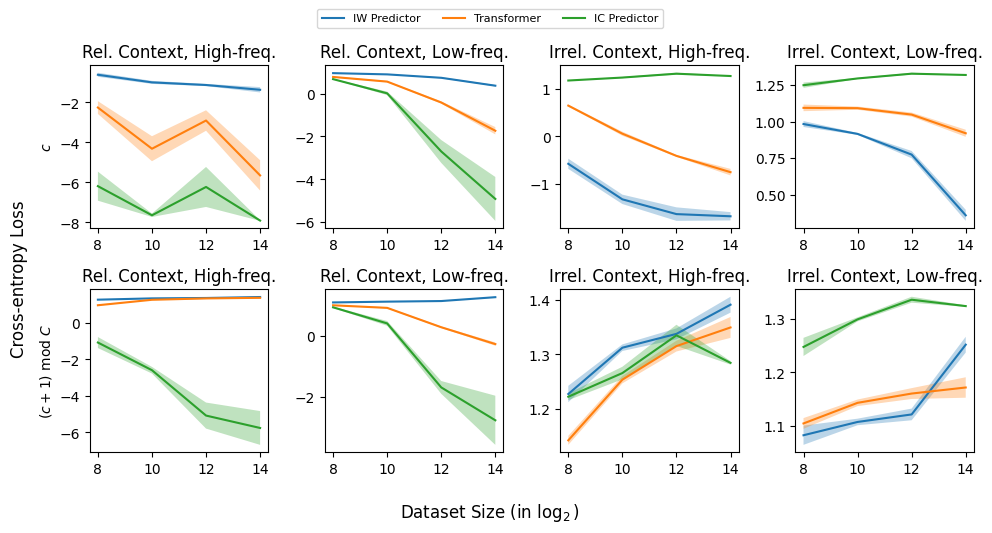

In [8]:
map_label = {
    0.0: "IW Predictor",
    1.0: "IC Predictor",
    0.9: "Transformer",
}
map_eval = {
    "eval-relevant_context-high_prob": "Rel. Context, High-freq.",
    "eval-relevant_context-low_prob": "Rel. Context, Low-freq.",
    "eval-irrelevant_context-high_prob": "Irrel. Context, High-freq.",
    "eval-irrelevant_context-low_prob": "Irrel. Context, Low-freq.",
    "eval-relevant_context-high_prob-flip_label": "Rel. Context, High-freq.",
    "eval-relevant_context-low_prob-flip_label": "Rel. Context, Low-freq.",
    "eval-irrelevant_context-high_prob-flip_label": "Irrel. Context, High-freq.",
    "eval-irrelevant_context-low_prob-flip_label": "Irrel. Context, Low-freq.",
}

# fig, axes = plt.subplots(2, 2, figsize=(10, 8))
fig, axes = plt.subplots(2, 4, figsize=(10, 5))
eval_namess = [
    [
        "eval-relevant_context-high_prob",
        "eval-relevant_context-low_prob",
        "eval-irrelevant_context-high_prob",
        "eval-irrelevant_context-low_prob",
    ],
    [
        "eval-relevant_context-high_prob-flip_label",
        "eval-relevant_context-low_prob-flip_label",
        "eval-irrelevant_context-high_prob-flip_label",
        "eval-irrelevant_context-low_prob-flip_label",
    ],
]
for row_i, eval_names in enumerate(eval_namess):
    for eval_i, eval_name in enumerate(eval_names):
        ax = axes[row_i, eval_i]
        # ax = axes[eval_i]
        for p_relevant_context in [0.0, 0.9, 1.0]:
            losses_mean = []
            losses_std = []

            for dataset_size in dataset_sizes:
                data = np.log10(np.array(stats[
                    (stats["p_relevant_context"] == f"{p_relevant_context}")
                    & (stats["stats_key"] == "loss")
                    & (stats["eval_name"] == eval_name)
                    & (stats["dataset_size"] == f"{dataset_size}")
                ]["stats"].to_list()))
                losses_mean.append(np.mean(data, axis=0)[-1])
                losses_std.append(np.std(data, axis=0)[-1])

            losses_mean = np.array(losses_mean)
            losses_std = np.array(losses_std) / np.sqrt(5)

            ax.plot(np.log2(np.array(dataset_sizes)), losses_mean, label=map_label[p_relevant_context] if eval_i == 0 and row_i == 0 else "")
            ax.fill_between(np.log2(np.array(dataset_sizes)), losses_mean - losses_std, losses_mean + losses_std, alpha=0.3)

        ax.set_title(map_eval[eval_name])
        # ax.set_ylim(-1.0, 1.5)
        if eval_i == 0:
            ax.set_ylabel("$c$" if row_i == 0 else "$(c + 1) \\text{ mod } C$")

fig.supylabel("Cross-entropy Loss")
fig.supxlabel("Dataset Size (in $\\log_2$)")
fig.legend(
    bbox_to_anchor=(0.0, 1.0, 1.0, 0.0),
    loc="lower center",
    ncols=4,
    borderaxespad=0.0,
    frameon=True,
    fontsize="8", 
)
fig.tight_layout()
plt.show()

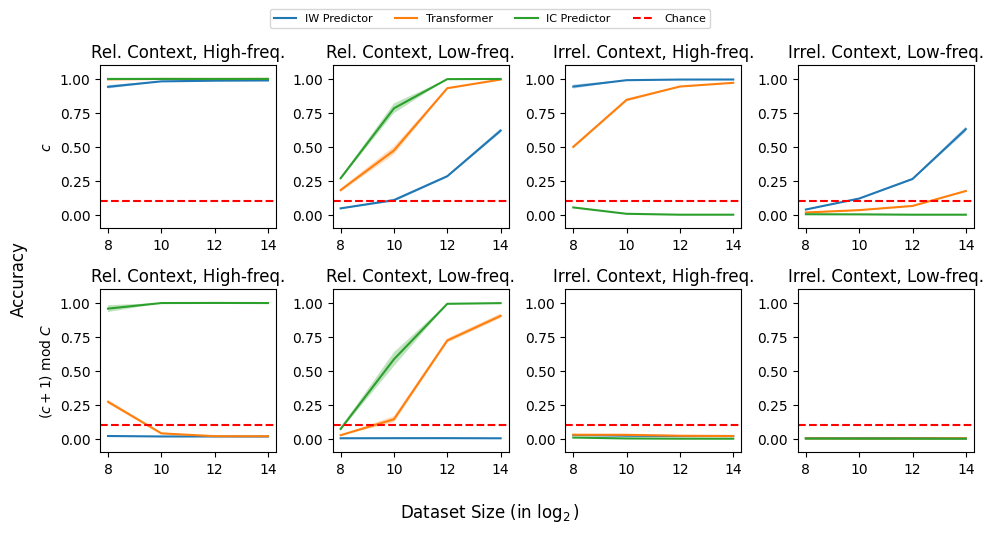

In [9]:
map_label = {
    0.0: "IW Predictor",
    1.0: "IC Predictor",
    0.9: "Transformer",
}
map_eval = {
    "eval-relevant_context-high_prob": "Rel. Context, High-freq.",
    "eval-relevant_context-low_prob": "Rel. Context, Low-freq.",
    "eval-irrelevant_context-high_prob": "Irrel. Context, High-freq.",
    "eval-irrelevant_context-low_prob": "Irrel. Context, Low-freq.",
    "eval-relevant_context-high_prob-flip_label": "Rel. Context, High-freq.",
    "eval-relevant_context-low_prob-flip_label": "Rel. Context, Low-freq.",
    "eval-irrelevant_context-high_prob-flip_label": "Irrel. Context, High-freq.",
    "eval-irrelevant_context-low_prob-flip_label": "Irrel. Context, Low-freq.",
}

# fig, axes = plt.subplots(2, 2, figsize=(10, 8))
fig, axes = plt.subplots(2, 4, figsize=(10, 5))
eval_namess = [
    [
        "eval-relevant_context-high_prob",
        "eval-relevant_context-low_prob",
        "eval-irrelevant_context-high_prob",
        "eval-irrelevant_context-low_prob",
    ],
    [
        "eval-relevant_context-high_prob-flip_label",
        "eval-relevant_context-low_prob-flip_label",
        "eval-irrelevant_context-high_prob-flip_label",
        "eval-irrelevant_context-low_prob-flip_label",
    ],
]
for row_i, eval_names in enumerate(eval_namess):
    for eval_i, eval_name in enumerate(eval_names):
        ax = axes[row_i, eval_i]
        # ax = axes[eval_i]
        for p_relevant_context in [0.0, 0.9, 1.0]:
            losses_mean = []
            losses_std = []

            for dataset_size in dataset_sizes:
                data = (np.array(stats[
                    (stats["p_relevant_context"] == f"{p_relevant_context}")
                    & (stats["stats_key"] == "accuracy")
                    & (stats["eval_name"] == eval_name)
                    & (stats["dataset_size"] == f"{dataset_size}")
                ]["stats"].to_list()))
                losses_mean.append(np.mean(data, axis=0)[-1])
                losses_std.append(np.std(data, axis=0)[-1])

            losses_mean = np.array(losses_mean)
            losses_std = np.array(losses_std) / np.sqrt(5)

            ax.plot(np.log2(np.array(dataset_sizes)), losses_mean, label=map_label[p_relevant_context] if eval_i == 0 and row_i == 0 else "")
            ax.fill_between(np.log2(np.array(dataset_sizes)), losses_mean - losses_std, losses_mean + losses_std, alpha=0.3)

        ax.set_title(map_eval[eval_name])
        ax.axhline(1/10, label="Chance" if eval_i == 0 and row_i == 0 else "", c="red", linestyle="--")
        ax.set_ylim(-0.1, 1.1)

        if eval_i == 0:
            ax.set_ylabel("$c$" if row_i == 0 else "$(c + 1) \\text{ mod } C$")

fig.supylabel("Accuracy")
fig.supxlabel("Dataset Size (in $\\log_2$)")
fig.legend(
    bbox_to_anchor=(0.0, 1.0, 1.0, 0.0),
    loc="lower center",
    ncols=4,
    borderaxespad=0.0,
    frameon=True,
    fontsize="8", 
)
fig.tight_layout()
plt.show()

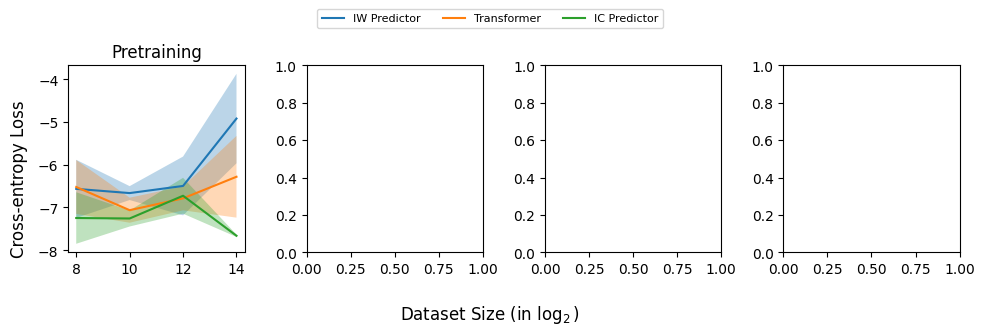

In [10]:
map_label = {
    0.0: "IW Predictor",
    1.0: "IC Predictor",
    0.9: "Transformer",
}
map_eval = {
    "eval-relevant_context-high_prob-flip_label": "Rel. Context, High-freq.",
    "eval-relevant_context-low_prob-flip_label": "Rel. Context, Low-freq.",
    "eval-irrelevant_context-high_prob-flip_label": "Irrel. Context, High-freq.",
    "eval-irrelevant_context-low_prob-flip_label": "Irrel. Context, Low-freq.",
    "pretraining": "Pretraining",
}

fig, axes = plt.subplots(1, 4, figsize=(10, 3))
for eval_i, eval_name in enumerate([
    "pretraining",
]):
    # ax = axes[eval_i // 2, eval_i % 2]
    ax = axes[eval_i]
    for p_relevant_context in [0.0, 0.9, 1.0]:
        losses_mean = []
        losses_std = []

        for dataset_size in dataset_sizes:
            data = np.log10(np.array(stats[
                (stats["p_relevant_context"] == f"{p_relevant_context}")
                & (stats["stats_key"] == "loss")
                & (stats["eval_name"] == eval_name)
                & (stats["dataset_size"] == f"{dataset_size}")
            ]["stats"].to_list()))
            losses_mean.append(np.mean(data, axis=0)[-1])
            losses_std.append(np.std(data, axis=0)[-1])

        losses_mean = np.array(losses_mean)
        losses_std = np.array(losses_std) / np.sqrt(5)

        ax.plot(np.log2(np.array(dataset_sizes)), losses_mean, label=map_label[p_relevant_context] if eval_i == 0 else "")
        ax.fill_between(np.log2(np.array(dataset_sizes)), losses_mean - losses_std, losses_mean + losses_std, alpha=0.3)

    ax.set_title(map_eval[eval_name])

fig.supylabel("Cross-entropy Loss")
fig.supxlabel("Dataset Size (in $\\log_2$)")
fig.legend(
    bbox_to_anchor=(0.0, 1.0, 1.0, 0.0),
    loc="lower center",
    ncols=4,
    borderaxespad=0.0,
    frameon=True,
    fontsize="8", 
)
fig.tight_layout()
plt.show()

## Number of Contexts

In [ ]:
map_label = {
    0.0: "IW Predictor",
    1.0: "IC Predictor",
    0.9: "Transformer",
}
map_eval = {
    "eval-relevant_context-high_prob": "Rel. Context, High-freq.",
    "eval-relevant_context-low_prob": "Rel. Context, Low-freq.",
    "eval-irrelevant_context-high_prob": "Irrel. Context, High-freq.",
    "eval-irrelevant_context-low_prob": "Irrel. Context, Low-freq.",
    "eval-relevant_context-high_prob-flip_label": "Rel. Context, High-freq.",
    "eval-relevant_context-low_prob-flip_label": "Rel. Context, Low-freq.",
    "eval-irrelevant_context-high_prob-flip_label": "Irrel. Context, High-freq.",
    "eval-irrelevant_context-low_prob-flip_label": "Irrel. Context, Low-freq.",
}

# fig, axes = plt.subplots(2, 2, figsize=(10, 8))
eval_namess = [
    [
        "eval-relevant_context-high_prob",
        "eval-relevant_context-low_prob",
        "eval-irrelevant_context-high_prob",
        "eval-irrelevant_context-low_prob",
    ],
    [
        "eval-relevant_context-high_prob-flip_label",
        "eval-relevant_context-low_prob-flip_label",
        "eval-irrelevant_context-high_prob-flip_label",
        "eval-irrelevant_context-low_prob-flip_label",
    ],
]

num_contextss = sorted([int(num_contexts) for num_contexts in stats["num_contexts"].unique()])
for num_contexts in num_contextss:
    fig, axes = plt.subplots(2, 4, figsize=(10, 5))
    for row_i, eval_names in enumerate(eval_namess):
        for eval_i, eval_name in enumerate(eval_names):
            ax = axes[row_i, eval_i]
            # ax = axes[eval_i]
            for p_relevant_context in [0.0, 0.9, 1.0]:
                losses_mean = []
                losses_std = []

                for dataset_size in dataset_sizes:
                    data = np.log10(np.array(stats[
                        (stats["p_relevant_context"] == f"{p_relevant_context}")
                        & (stats["stats_key"] == "loss")
                        & (stats["eval_name"] == eval_name)
                        & (stats["num_contexts"] == f"{num_contexts}")
                        & (stats["dataset_size"] == f"{dataset_size}")
                    ]["stats"].to_list()))
                    losses_mean.append(np.mean(data, axis=0)[-1])
                    losses_std.append(np.std(data, axis=0)[-1])

                losses_mean = np.array(losses_mean)
                losses_std = np.array(losses_std) / np.sqrt(5)

                ax.plot(np.log2(np.array(dataset_sizes)), losses_mean, label=map_label[p_relevant_context] if eval_i == 0 and row_i == 0 else "")
                ax.fill_between(np.log2(np.array(dataset_sizes)), losses_mean - losses_std, losses_mean + losses_std, alpha=0.3)

            ax.set_title(map_eval[eval_name])
            ax.set_ylim(-1.5, 1.5)
            if eval_i == 0:
                ax.set_ylabel("$c$" if row_i == 0 else "$(c + 1) \\text{ mod } C$")

    fig.suptitle("Context Length: {}".format(num_contexts))
    fig.supylabel("Cross-entropy Loss")
    fig.supxlabel("Dataset Size (in $\\log_2$)")
    fig.legend(
        bbox_to_anchor=(0.0, 1.0, 1.0, 0.0),
        loc="lower center",
        ncols=4,
        borderaxespad=0.0,
        frameon=True,
        fontsize="8", 
    )
    fig.tight_layout()
    plt.show()

    

In [ ]:
map_label = {
    0.0: "IW Predictor",
    1.0: "IC Predictor",
    0.9: "Transformer",
}
map_eval = {
    "eval-relevant_context-high_prob": "Rel. Context, High-freq.",
    "eval-relevant_context-low_prob": "Rel. Context, Low-freq.",
    "eval-irrelevant_context-high_prob": "Irrel. Context, High-freq.",
    "eval-irrelevant_context-low_prob": "Irrel. Context, Low-freq.",
    "eval-relevant_context-high_prob-flip_label": "Rel. Context, High-freq.",
    "eval-relevant_context-low_prob-flip_label": "Rel. Context, Low-freq.",
    "eval-irrelevant_context-high_prob-flip_label": "Irrel. Context, High-freq.",
    "eval-irrelevant_context-low_prob-flip_label": "Irrel. Context, Low-freq.",
}

# fig, axes = plt.subplots(2, 2, figsize=(10, 8))
eval_namess = [
    [
        "eval-relevant_context-high_prob",
        "eval-relevant_context-low_prob",
        "eval-irrelevant_context-high_prob",
        "eval-irrelevant_context-low_prob",
    ],
    [
        "eval-relevant_context-high_prob-flip_label",
        "eval-relevant_context-low_prob-flip_label",
        "eval-irrelevant_context-high_prob-flip_label",
        "eval-irrelevant_context-low_prob-flip_label",
    ],
]

num_contextss = sorted([int(num_contexts) for num_contexts in stats["num_contexts"].unique()])
for num_contexts in num_contextss:
    fig, axes = plt.subplots(2, 4, figsize=(10, 5))
    for row_i, eval_names in enumerate(eval_namess):
        for eval_i, eval_name in enumerate(eval_names):
            ax = axes[row_i, eval_i]
            # ax = axes[eval_i]
            for p_relevant_context in [0.0, 0.9, 1.0]:
                losses_mean = []
                losses_std = []

                for dataset_size in dataset_sizes:
                    data = (np.array(stats[
                        (stats["p_relevant_context"] == f"{p_relevant_context}")
                        & (stats["stats_key"] == "accuracy")
                        & (stats["eval_name"] == eval_name)
                        & (stats["num_contexts"] == f"{num_contexts}")
                        & (stats["dataset_size"] == f"{dataset_size}")
                    ]["stats"].to_list()))
                    losses_mean.append(np.mean(data, axis=0)[-1])
                    losses_std.append(np.std(data, axis=0)[-1])

                losses_mean = np.array(losses_mean)
                losses_std = np.array(losses_std) / np.sqrt(5)

                ax.plot(np.log2(np.array(dataset_sizes)), losses_mean, label=map_label[p_relevant_context] if eval_i == 0 and row_i == 0 else "")
                ax.fill_between(np.log2(np.array(dataset_sizes)), losses_mean - losses_std, losses_mean + losses_std, alpha=0.3)

            ax.set_title(map_eval[eval_name])
            ax.axhline(1/10, label="Chance" if eval_i == 0 and row_i == 0 else "", c="red", linestyle="--")
            ax.set_ylim(-0.1, 1.1)

            if eval_i == 0:
                ax.set_ylabel("$c$" if row_i == 0 else "$(c + 1) \\text{ mod } C$")

    fig.suptitle("Context Length: {}".format(num_contexts))
    fig.supylabel("Accuracy")
    fig.supxlabel("Dataset Size (in $\\log_2$)")
    fig.legend(
        bbox_to_anchor=(0.0, 1.0, 1.0, 0.0),
        loc="lower center",
        ncols=4,
        borderaxespad=0.0,
        frameon=True,
        fontsize="8", 
    )
    fig.tight_layout()
    plt.show()

    

## Number of Relevant Contexts

In [ ]:
stats["p_relevant_context"].unique()

In [ ]:
stats.keys()

In [ ]:
map_label = {
    0.0: "IW Predictor",
    1.0: "IC Predictor",
    0.9: "Transformer",
}
map_eval = {
    "eval-relevant_context-high_prob": "Rel. Context, High-freq.",
    "eval-relevant_context-low_prob": "Rel. Context, Low-freq.",
    "eval-irrelevant_context-high_prob": "Irrel. Context, High-freq.",
    "eval-irrelevant_context-low_prob": "Irrel. Context, Low-freq.",
    "eval-relevant_context-high_prob-flip_label": "Rel. Context, High-freq.",
    "eval-relevant_context-low_prob-flip_label": "Rel. Context, Low-freq.",
    "eval-irrelevant_context-high_prob-flip_label": "Irrel. Context, High-freq.",
    "eval-irrelevant_context-low_prob-flip_label": "Irrel. Context, Low-freq.",
}

# fig, axes = plt.subplots(2, 2, figsize=(10, 8))
eval_namess = [
    [
        "eval-relevant_context-high_prob",
        "eval-relevant_context-low_prob",
        "eval-irrelevant_context-high_prob",
        "eval-irrelevant_context-low_prob",
    ],
    [
        "eval-relevant_context-high_prob-flip_label",
        "eval-relevant_context-low_prob-flip_label",
        "eval-irrelevant_context-high_prob-flip_label",
        "eval-irrelevant_context-low_prob-flip_label",
    ],
]

num_relevant_contextss = sorted([int(num_relevant_contexts) for num_relevant_contexts in stats["num_relevant_contexts"].unique()])
for num_relevant_contexts in num_relevant_contextss:
    fig, axes = plt.subplots(2, 4, figsize=(10, 5))
    for row_i, eval_names in enumerate(eval_namess):
        for eval_i, eval_name in enumerate(eval_names):
            ax = axes[row_i, eval_i]
            # ax = axes[eval_i]
            for p_relevant_context in [0.0, 0.9, 1.0]:
                losses_mean = []
                losses_std = []

                for dataset_size in dataset_sizes:
                    data = np.log10(np.array(stats[
                        (stats["p_relevant_context"] == f"{p_relevant_context}")
                        & (stats["stats_key"] == "loss")
                        & (stats["eval_name"] == eval_name)
                        & (stats["num_relevant_contexts"] == f"{num_relevant_contexts}")
                        & (stats["dataset_size"] == f"{dataset_size}")
                    ]["stats"].to_list()))
                    losses_mean.append(np.mean(data, axis=0)[-1])
                    losses_std.append(np.std(data, axis=0)[-1])

                losses_mean = np.array(losses_mean)
                losses_std = np.array(losses_std) / np.sqrt(5)

                ax.plot(np.log2(np.array(dataset_sizes)), losses_mean, label=map_label[p_relevant_context] if eval_i == 0 and row_i == 0 else "")
                ax.fill_between(np.log2(np.array(dataset_sizes)), losses_mean - losses_std, losses_mean + losses_std, alpha=0.3)

            ax.set_title(map_eval[eval_name])
            ax.set_ylim(-1.5, 1.5)

            if eval_i == 0:
                ax.set_ylabel("$c$" if row_i == 0 else "$(c + 1) \\text{ mod } C$")

    fig.suptitle("Num. Relevant Context: {}".format(num_relevant_contexts))
    fig.supylabel("Cross-entropy Loss")
    fig.supxlabel("Dataset Size (in $\\log_2$)")
    fig.legend(
        bbox_to_anchor=(0.0, 1.0, 1.0, 0.0),
        loc="lower center",
        ncols=4,
        borderaxespad=0.0,
        frameon=True,
        fontsize="8", 
    )
    fig.tight_layout()
    plt.show()

    

In [ ]:
map_label = {
    0.0: "IW Predictor",
    1.0: "IC Predictor",
    0.9: "Transformer",
}
map_eval = {
    "eval-relevant_context-high_prob": "Rel. Context, High-freq.",
    "eval-relevant_context-low_prob": "Rel. Context, Low-freq.",
    "eval-irrelevant_context-high_prob": "Irrel. Context, High-freq.",
    "eval-irrelevant_context-low_prob": "Irrel. Context, Low-freq.",
    "eval-relevant_context-high_prob-flip_label": "Rel. Context, High-freq.",
    "eval-relevant_context-low_prob-flip_label": "Rel. Context, Low-freq.",
    "eval-irrelevant_context-high_prob-flip_label": "Irrel. Context, High-freq.",
    "eval-irrelevant_context-low_prob-flip_label": "Irrel. Context, Low-freq.",
}

# fig, axes = plt.subplots(2, 2, figsize=(10, 8))
eval_namess = [
    [
        "eval-relevant_context-high_prob",
        "eval-relevant_context-low_prob",
        "eval-irrelevant_context-high_prob",
        "eval-irrelevant_context-low_prob",
    ],
    [
        "eval-relevant_context-high_prob-flip_label",
        "eval-relevant_context-low_prob-flip_label",
        "eval-irrelevant_context-high_prob-flip_label",
        "eval-irrelevant_context-low_prob-flip_label",
    ],
]

num_relevant_contextss = sorted([int(num_relevant_contexts) for num_relevant_contexts in stats["num_relevant_contexts"].unique()])
for num_relevant_contexts in num_relevant_contextss:
    fig, axes = plt.subplots(2, 4, figsize=(10, 5))
    for row_i, eval_names in enumerate(eval_namess):
        for eval_i, eval_name in enumerate(eval_names):
            ax = axes[row_i, eval_i]
            # ax = axes[eval_i]
            for p_relevant_context in [0.0, 0.9, 1.0]:
                losses_mean = []
                losses_std = []

                for dataset_size in dataset_sizes:
                    data = (np.array(stats[
                        (stats["p_relevant_context"] == f"{p_relevant_context}")
                        & (stats["stats_key"] == "accuracy")
                        & (stats["eval_name"] == eval_name)
                        & (stats["num_relevant_contexts"] == f"{num_relevant_contexts}")
                        & (stats["dataset_size"] == f"{dataset_size}")
                    ]["stats"].to_list()))
                    losses_mean.append(np.mean(data, axis=0)[-1])
                    losses_std.append(np.std(data, axis=0)[-1])

                losses_mean = np.array(losses_mean)
                losses_std = np.array(losses_std) / np.sqrt(5)

                ax.plot(np.log2(np.array(dataset_sizes)), losses_mean, label=map_label[p_relevant_context] if eval_i == 0 and row_i == 0 else "")
                ax.fill_between(np.log2(np.array(dataset_sizes)), losses_mean - losses_std, losses_mean + losses_std, alpha=0.3)

            ax.set_title(map_eval[eval_name])
            ax.axhline(1/10, label="Chance" if eval_i == 0 and row_i == 0 else "", c="red", linestyle="--")
            ax.set_ylim(-0.1, 1.1)

            if eval_i == 0:
                ax.set_ylabel("$c$" if row_i == 0 else "$(c + 1) \\text{ mod } C$")

    fig.suptitle("Num. Relevant Context: {}".format(num_relevant_contexts))
    fig.supylabel("Accuracy")
    fig.supxlabel("Dataset Size (in $\\log_2$)")
    fig.legend(
        bbox_to_anchor=(0.0, 1.0, 1.0, 0.0),
        loc="lower center",
        ncols=4,
        borderaxespad=0.0,
        frameon=True,
        fontsize="8", 
    )
    fig.tight_layout()
    plt.show()

    